# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

## Imports

In [6]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import os



In [52]:
!pip install dlai-grader

## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
data_dir = "/content/drive/MyDrive/ColabDatasets"
train_dir = os.path.join(data_dir, "seg_train")
val_dir   = os.path.join(data_dir, "seg_test")

In [12]:
import os

extract_dir = "/content/dataset"
os.makedirs(extract_dir, exist_ok=True)

!unzip -q "/content/drive/MyDrive/ColabDatasets/dataset.zip" -d $extract_dir


In [13]:
!ls /content/dataset

seg_pred  seg_test  seg_train


In [14]:
!ls $data_dir

dataset.zip


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [18]:
train_dataset = datasets.ImageFolder(
    root=os.path.join(extract_dir, "seg_train")
)

test_dataset = datasets.ImageFolder(
    root=os.path.join(extract_dir, "seg_test")
)


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [21]:
print("Train samples:", len(train_dataset))
print("Validation samples:", len(test_dataset))
print("Classes:", train_dataset.classes)

Train samples: 14034
Validation samples: 3000
Classes: ['seg_train']


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [43]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
}


In [44]:

# Attach transforms to datasets
train_dataset.transform = data_transforms['train']
test_dataset.transform  = data_transforms['val']

from torch.utils.data import DataLoader
# Create DataLoaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'val': DataLoader(test_dataset, batch_size=32, shuffle=False)
}


**Quick Check**: Visualize a batch of training images

In [60]:
from google.colab import files
files.upload()


Saving helper_utils.py to helper_utils.py


{'helper_utils.py': b'"""\nHelper utilities for the Weekly Project on Transfer Learning.\nContains functions for visualizing images, predictions, and training progress.\n"""\n\nimport matplotlib.pyplot as plt\nimport numpy as np\nimport torch\nimport torchvision\n\n\ndef imshow(inp, title=None, ax=None):\n    """\n    Display image for Tensor.\n    \n    Args:\n        inp: Tensor image of shape (C, H, W) or (H, W, C)\n        title: Optional title for the image\n        ax: Optional matplotlib axis to plot on\n    """\n    if ax is None:\n        fig, ax = plt.subplots(1, 1, figsize=(6, 6))\n    \n    # Convert tensor to numpy if needed\n    if isinstance(inp, torch.Tensor):\n        inp = inp.numpy()\n    \n    # Handle different input shapes\n    if inp.shape[0] == 3 or inp.shape[0] == 1:  # (C, H, W)\n        inp = inp.transpose((1, 2, 0))\n    \n    # Denormalize if needed (assuming ImageNet normalization)\n    if inp.min() < 0 or inp.max() > 1:\n        mean = np.array([0.485, 0.

In [61]:
import helper_utils

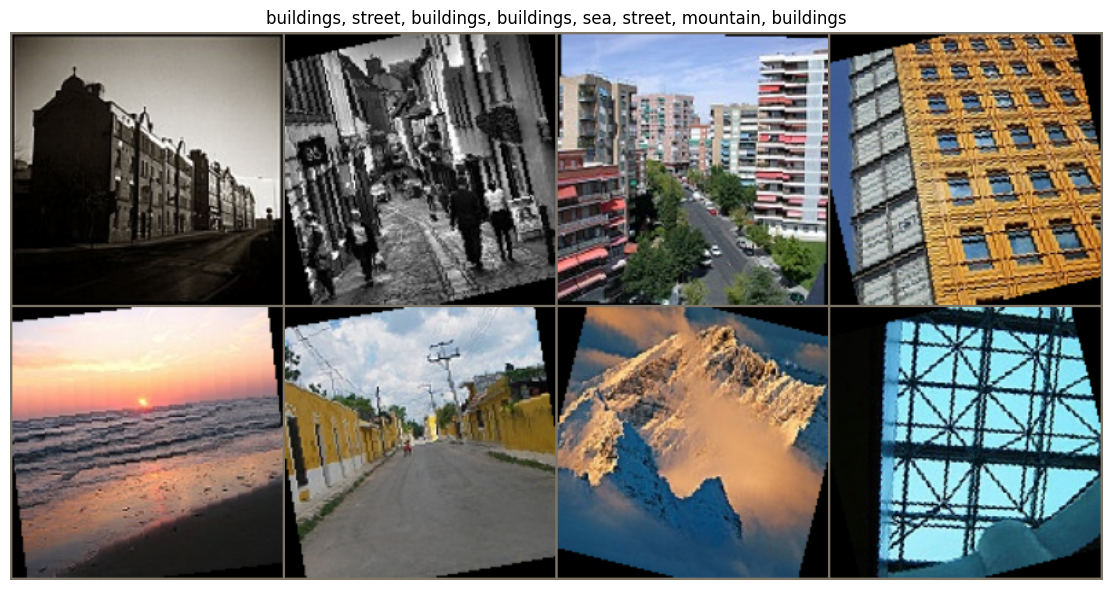

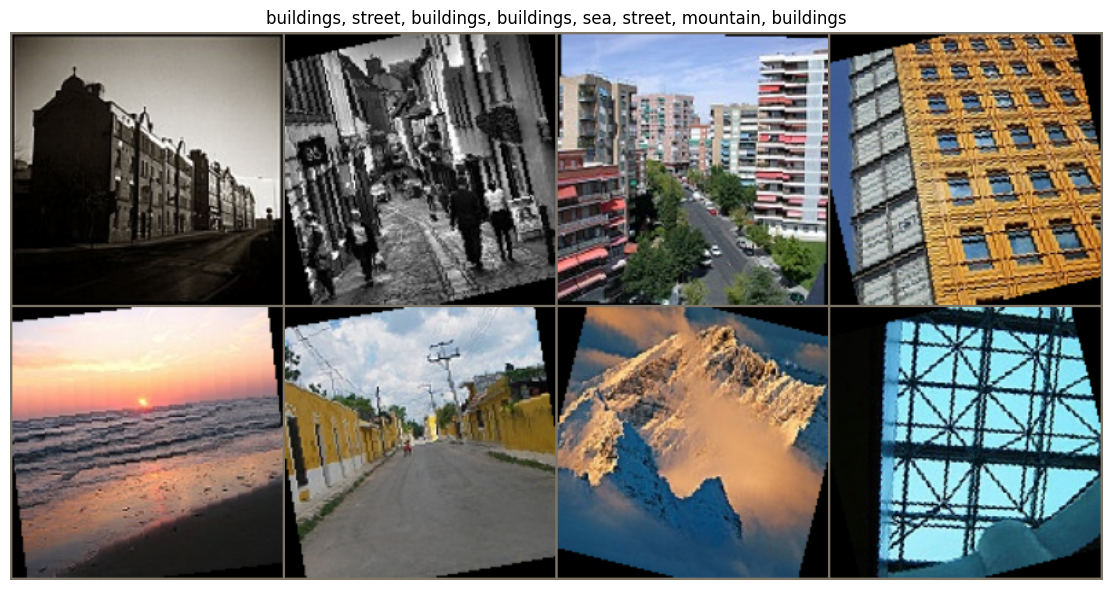

In [62]:
helper_utils.visualize_batch(
    dataloaders['train'],
    class_names=train_dataset.classes
)


<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [63]:
# Model Building
from torchvision import models
import torch.nn as nn

# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer to match 6 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)

# Move the model to the configured device (GPU/CPU)
model = model.to(device)

print(model)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 79.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=5):
    """
    General training function for PyTorch models
    """
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-"*20)

        # لكل مرحلة: train و val
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # تدريب
            else:
                model.eval()   # تقييم

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()  # صفّر التدرجات

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + step فقط في التدريب
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print()

    return model, history


<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [65]:
from torchvision import models
import torch.nn as nn

# Load a fresh ResNet-18 pre-trained model
model_conv = models.resnet18(pretrained=True)

# Modify the final layer for 6 classes
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 6)

# Move model to device (GPU/CPU)
model_conv = model_conv.to(device)


In [66]:
# Freeze all convolutional layers
for param in model_conv.parameters():
    param.requires_grad = False

# Ensure the final layer is trainable
for param in model_conv.fc.parameters():
    param.requires_grad = True


In [67]:
import torch.optim as optim
import torch.nn as nn

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: only the parameters of the final layer will be updated
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)


In [70]:
import torch
torch.cuda.is_available()  # يجب أن ترجع True


False

In [71]:
# Train the model using the general training function
model_conv, history_conv = train_model(
    model_conv,
    dataloaders,
    criterion,
    optimizer_conv,
    device,
    num_epochs=5
)


Epoch 1/5
--------------------


KeyboardInterrupt: 

**Quick Check**: Visualize training history

In [ ]:
# helper_utils.visualize_training_history(history_conv)
# plt.show()

**Quick Check**: Visualize predictions

In [ ]:
# helper_utils.visualize_predictions(model_conv, dataloaders['val'], class_names, device, num_images=6)
# plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

**Quick Check**: Visualize training history

In [ ]:
# helper_utils.visualize_training_history(history_ft)
# plt.show()

**Quick Check**: Visualize predictions

In [ ]:
# helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
# plt.show()

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [ ]:
# Evaluate models on validation set
# YOUR CODE HERE
# Compare final validation accuracies, training times, etc.

# Print comparison
# print("Feature Extractor Approach:")
# print(f"  Best Val Accuracy: {max(history_conv['val_acc']):.4f}")
# print(f"  Final Val Accuracy: {history_conv['val_acc'][-1]:.4f}")
# print()
# print("Fine-tuning Approach:")
# print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
# print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")

<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

In [ ]:
# Make prediction on a custom image
# img_path = 'path/to/your/image.jpg'

# YOUR CODE HERE
# Use helper_utils.visualize_single_prediction or helper_utils.predict_single_image
# helper_utils.visualize_single_prediction(
#     model_ft,  # or model_conv
#     img_path,
#     data_transforms['val'],
#     class_names,
#     device
# )
# plt.show()

# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [ ]:
# Convert model to ONNX
# YOUR CODE HERE

# Set model to evaluation mode
# model_ft.eval()

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
# dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
# onnx_path = 'model.onnx'
# torch.onnx.export(
#     model_ft,
#     dummy_input,
#     onnx_path,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
# )

# print(f"Model exported to {onnx_path}")

In [ ]:
# Load ONNX model and perform inference
# YOUR CODE HERE

# Load ONNX model
# ort_session = ort.InferenceSession(onnx_path)

# Prepare input (use validation transform)
# img_path = 'path/to/test/image.jpg'
# img = Image.open(img_path).convert('RGB')
# img_tensor = data_transforms['val'](img).unsqueeze(0)
# img_numpy = img_tensor.numpy()

# Run inference
# outputs = ort_session.run(None, {'input': img_numpy})
# predictions = np.array(outputs[0])
# pred_class_idx = np.argmax(predictions[0])
# pred_class = class_names[pred_class_idx]
# confidence = np.max(predictions[0])

# print(f"Predicted: {pred_class} (confidence: {confidence:.2%})")